In [14]:
#Imports -----------------------------------------
import csv
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.odr import ODR, Model, Data, RealData
from scipy.optimize import curve_fit
from numpy import linspace, pi, sqrt, log10


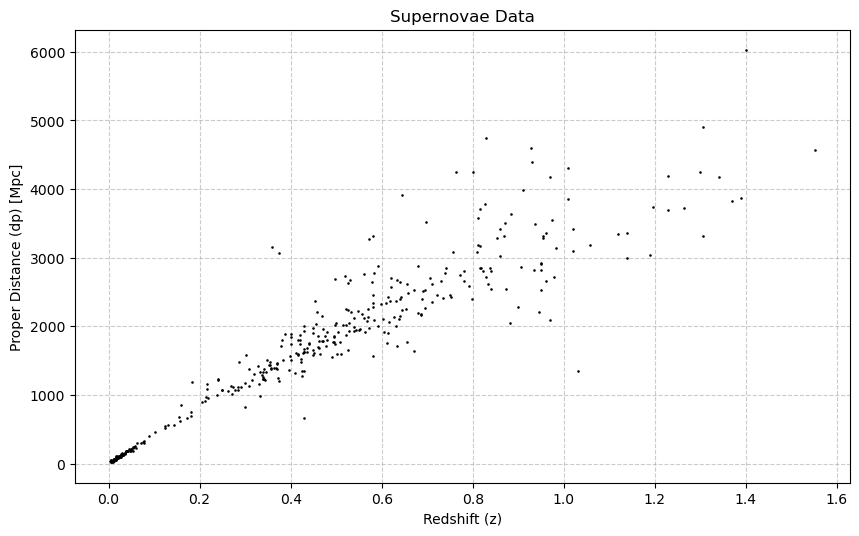

In [46]:
#Supernovae Data ---------------------------------

#This function reads a csv file to import supernovae data
def read_data(filename):
    with open(filename, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)[1:]
    z_data_list = []   #list for redshift values
    mu_data_list = []  #list for difference between apparent magnitude and absolute magnitude, m-M
    for row in data:
        if row[5] == '-':
            continue
        else:
            z_data_list.append(float(row[1]))
            mu_data_list.append(float(row[5]))
    return z_data_list, mu_data_list


#This function calculates the proper distance from the imported supernovae data
def dp_from_data(filename):
    z_data_list, mu_data_list = read_data(filename)
    dp_data_list = []  #list for proper distance values
    
    for value in range(len(z_data_list)):
        dp = (10**((mu_data_list[value]/5)-5))/(1+z_data_list[value])  #dp = 10^((mu-25)/5) / (1+z)
        dp_data_list.append(dp)
    return z_data_list, dp_data_list


#Plots supernovae data
z_data_list, dp_data_list = dp_from_data('supernovadata.csv')

plt.figure(figsize=(10,6),dpi=100)
plt.plot(z_data_list,dp_data_list,'o',markersize=0.85,color='black',label='Supernova Data')
plt.grid(True,alpha=0.6,linestyle='dashed',color='darkgray',which='both')
plt.title('Supernovae Data')
plt.xlabel('Redshift (z)')
plt.ylabel('Proper Distance (dp) [Mpc]')
plt.show()

In [47]:
#Proper Distance Integrals -----------------------

#Constants for Benchmark Model Universe
m0 = 0.3       #density of matter
r0 = 0.000084  #density of radiation
v0 = 0.7       #density of vacuum
c_H0 = 4117    #inverse hubble sphere radius r = H_0/c [Mpc]
    

#This function is used to calculate the proper distance for the Benchmark Model Universe
def dp_benchmark(a):
    return (c_H0)/sqrt((r0+(m0*a)+(v0*a**4)))


#This function is used to calculate the proper distance for a Radiation Only Universe
def dp_radiation(a):
    return (c_H0)


#This function is used to calculate the proper distance for a Matter Only Universe
def dp_matter(a):
    return (c_H0)/sqrt(a)


#This function is used to calculate the proper distance for a Vacuum Only Universe
def dp_vacuum(a):
    return (c_H0)/(a**2)


In [48]:
#Numerically approximating Integrals -------------

#Reads file with supernovae data and calls dp_from_data function
z_data_list, dp_data_list = dp_from_data('supernovadata.csv')

#Proper distance lists for each universe
dp_benchmark_list = []
dp_radiation_list = []
dp_matter_list = []
dp_vacuum_list = []
dp_universe_list = [dp_benchmark_list, dp_radiation_list, dp_matter_list, dp_vacuum_list]


#This loop numerically approximates the integral for the proper distance for each universe
z_range = linspace(min(z_data_list),max(z_data_list),100)

for z in z_range:
    #scipy.integrate.fixed_quad numerically approximates integral using nth order Gaussian quadrature
    benchmark = integrate.fixed_quad(dp_benchmark, 1/(1+z), 1, n=20)
    radiation = integrate.fixed_quad(dp_radiation, 1/(1+z), 1, n=20)
    matter = integrate.fixed_quad(dp_matter, 1/(1+z), 1, n=20)
    vacuum = integrate.fixed_quad(dp_vacuum, 1/(1+z), 1, n=20)
    
    #appends each proper distance value to respective universes
    #fixed_quad returns a tuple; [0] returns the float value of the approximation
    dp_benchmark_list.append(benchmark[0])
    dp_radiation_list.append(radiation[0])
    dp_matter_list.append(matter[0])
    dp_vacuum_list.append(vacuum[0])
    

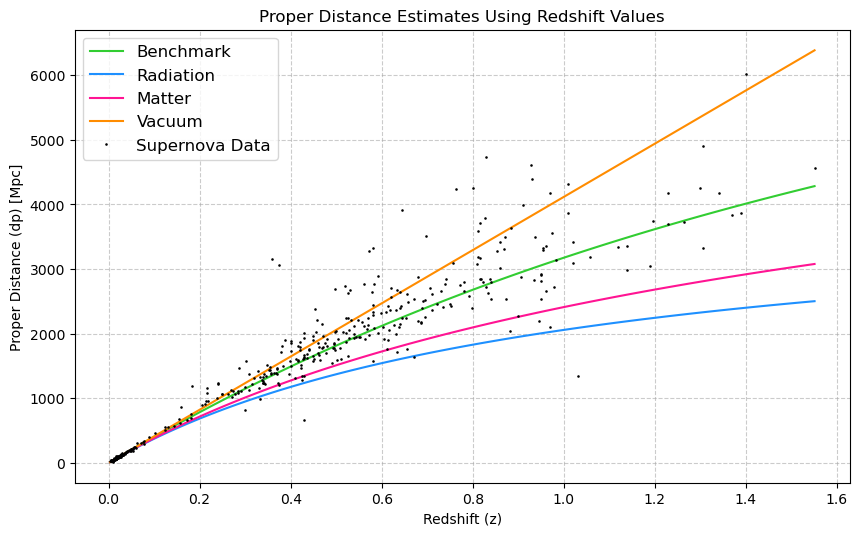

In [49]:
#Plotting Proper Distances vs Redshift -----------

#Colors and labels of each universe
color = ['limegreen','dodgerblue','deeppink','darkorange']
label = ['Benchmark','Radiation','Matter','Vacuum']

plt.figure(figsize=(10,6), dpi=100)

#This loop iterates through each universe in dp_universe_list and plots them vs redshift
for index in range(len(dp_universe_list)):
    plt.plot(z_range, dp_universe_list[index], linestyle='solid', color=color[index], label=label[index])

#Plots the supernovae data    
plt.plot(z_data_list, dp_data_list,'o', markersize=0.85, color='black', label='Supernova Data')

#Creates grid, legend, and titles
plt.grid(True, alpha=0.6, linestyle='dashed', color='darkgray', which='both')
plt.legend(prop={'size':12})
plt.rcParams['legend.loc'] = 'upper left'
plt.title('Proper Distance Estimates Using Redshift Values')
plt.xlabel('Redshift (z)')
plt.ylabel('Proper Distance (dp) [Mpc]')
plt.show()

[ 2.76233347e-05 -3.62397939e-03  1.10831595e+00 -1.03824338e+00
  7.90519820e-01]


<ipython-input-50-ed28a3c69df5>:4: RuntimeWarning: invalid value encountered in sqrt
  return (c_H0)*sqrt(params[0]+(params[1]*a)+(params[2]*a**2)+(params[3]*a**3)+(params[4]*a**4))


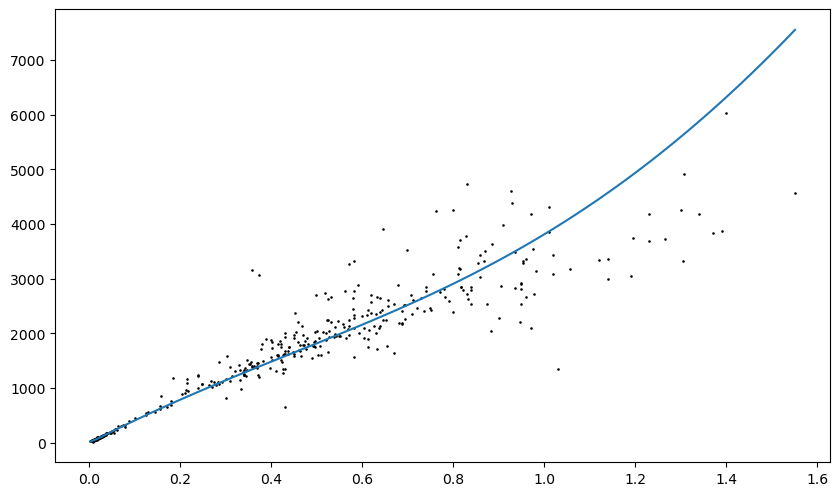

In [50]:
#Supernovae Data Curve-fitting -------------------

def dp_curvefit(params, a):
    return (c_H0)*sqrt(params[0]+(params[1]*a)+(params[2]*a**2)+(params[3]*a**3)+(params[4]*a**4))

data = RealData(z_data_list, dp_data_list)
model = Model(dp_curvefit)
pguess = [r0,m0,1,1,v0]
odr = ODR(data, model, pguess)
output = odr.run()
print(output.beta)

plt.figure(figsize=(10,6),dpi=100)
plt.plot(z_data_list,dp_data_list, 'o', markersize=0.85, color='black', label='Supernova Data')
plt.plot(z_range, dp_curvefit(output.beta, z_range))
plt.show()

In [51]:
#Finding Mu as function of redshift---------------

z_data_list, mu_data_list = read_data('supernovadata.csv')

#Mu (m-M) lists for each universe
mu_benchmark_list = []
mu_radiation_list = []
mu_matter_list = []
mu_vacuum_list = []
mu_universe_list = [mu_benchmark_list, mu_radiation_list, mu_matter_list, mu_vacuum_list]


#This loop determines theoretical mu values for each universe
for index in range(len(z_range)):
    #mu = 5log_10(dp*(1+z))+25
    mu_b = (5*log10(dp_benchmark_list[index]*(1+z_range[index])))+25
    mu_r = (5*log10(dp_radiation_list[index]*(1+z_range[index])))+25
    mu_m = (5*log10(dp_matter_list[index]*(1+z_range[index])))+25
    mu_v = (5*log10(dp_vacuum_list[index]*(1+z_range[index])))+25
    
    #appends each mu value to respective universes
    mu_benchmark_list.append(mu_b)
    mu_radiation_list.append(mu_r)
    mu_matter_list.append(mu_m)
    mu_vacuum_list.append(mu_v)


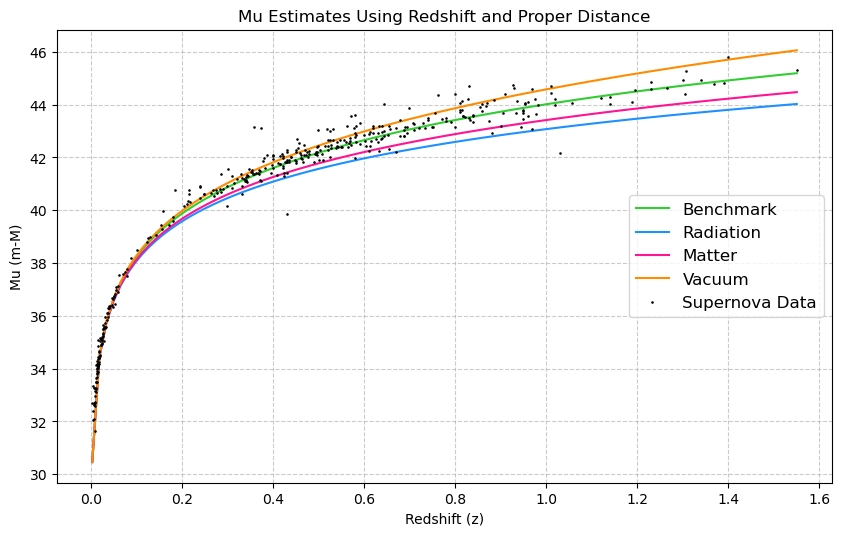

In [53]:
#Plotting Mu vs redshift -------------------------

plt.figure(figsize=(10,6), dpi=100)

#This loop iterates through each universe in dp_universe_list and plots them vs redshift
for index in range(len(mu_universe_list)):
    plt.plot(z_range, mu_universe_list[index], linestyle='solid', color=color[index], label=label[index])

#Plots the supernovae data    
plt.plot(z_data_list, mu_data_list,'o', markersize=0.85, color='black', label='Supernova Data')

#Creates grid, legend, and titles
plt.grid(True, alpha=0.6, linestyle='dashed', color='darkgray', which='both')
plt.legend(prop={'size':12})
plt.rcParams['legend.loc'] = 'right'
plt.title('Mu Estimates Using Redshift and Proper Distance')
plt.xlabel('Redshift (z)')
plt.ylabel('Mu (m-M)')
plt.show()